In [1]:
import os
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras import regularizers

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


In [2]:
base_path = '/Users/nicholastey/Desktop/thesis/gnss_spoof_detector/spoof_detector/data/'

In [3]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [4]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
  tmp_path = os.path.join(base_path, ds_fname)
  key = ds_fname.split('.')[0]
  
  tmp_df = pd.read_csv(tmp_path, header=None)
  prn_li = []
  for i in range(8):
    prn_li.append(int(tmp_df.iloc[1, 11*i+1]))
  globals()[f'{key}_dict'] = {
      int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:9].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:20].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:31].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:42].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:53].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:64].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:75].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:86].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      'prn' : prn_li
  }

dicts = [cs_dict, ds1_dict, ds2_dict, ds3_dict, ds4_dict, ds7_dict, ds8_dict]

In [5]:
big_df = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df = dataset[prn].copy()
        df['spoofed'] = label
        df['prn'] = prn
        big_df.append(df)

big_df = pd.concat(big_df, ignore_index=True)
big_df

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,spoofed,prn
0,0.0,0.0000,0.000000,0.00000,0,13
1,0.0,0.0000,0.000000,0.00000,0,13
2,0.0,0.0000,0.000000,0.00000,0,13
3,0.0,0.0000,0.000000,0.00000,0,13
4,0.0,0.0000,0.000000,0.00000,0,13
...,...,...,...,...,...,...
189267,0.0,0.0000,0.000000,0.00000,6,16
189268,0.0,0.0000,0.000000,0.00000,6,16
189269,0.0,0.0000,0.000000,0.00000,6,16
189270,0.0,0.0000,0.000000,0.00000,6,16


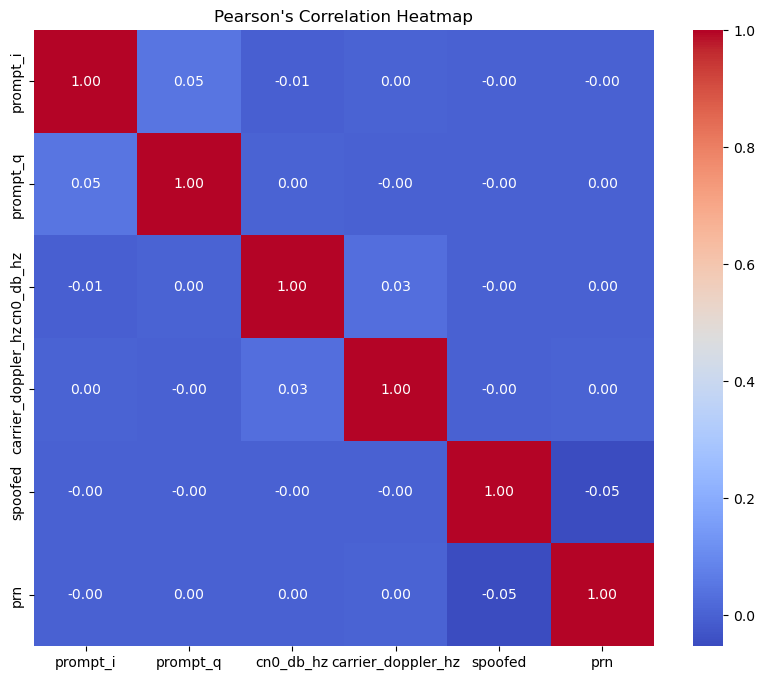

In [6]:
# Compute the correlation matrix
correlation_matrix = big_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [7]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
  tmp_path = os.path.join(base_path, ds_fname)
  key = ds_fname.split('.')[0]
  
  tmp_df = pd.read_csv(tmp_path, header=None)
  prn_li = []
  for i in range(8):
    prn_li.append(int(tmp_df.iloc[1, 11*i+1]))
  globals()[f'{key}_dict'] = {
      int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:9].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].fillna(0),
      int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:20].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].fillna(0),
      int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:31].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].fillna(0),
      int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:42].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].fillna(0),
      int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:53].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].fillna(0),
      int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:64].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].fillna(0),
      int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:75].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].fillna(0),
      int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:86].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].fillna(0),
      'prn' : prn_li
  }

dicts = [cs_dict, ds1_dict, ds2_dict, ds3_dict, ds4_dict, ds7_dict, ds8_dict]

In [8]:
big_df_no_diff = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df_no_diff = dataset[prn].copy()
        df_no_diff['spoofed'] = label
        df_no_diff['prn'] = prn
        big_df_no_diff.append(df_no_diff)

big_df_no_diff = pd.concat(big_df_no_diff, ignore_index=True)
big_df_no_diff

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,spoofed,prn
0,-121029744.0,1.263441e+04,49.919094,1812.986210,0,13
1,-121029744.0,1.263441e+04,49.919094,1812.986210,0,13
2,-121029744.0,1.263441e+04,49.919094,1812.986210,0,13
3,-121029744.0,1.263441e+04,49.919094,1812.986210,0,13
4,-121029744.0,1.263441e+04,49.919094,1812.986210,0,13
...,...,...,...,...,...,...
189267,-89691576.0,-1.508410e+06,47.438442,-2888.333635,6,16
189268,-89691576.0,-1.508410e+06,47.438442,-2888.333635,6,16
189269,-89691576.0,-1.508410e+06,47.438442,-2888.333635,6,16
189270,-89691576.0,-1.508410e+06,47.438442,-2888.333635,6,16


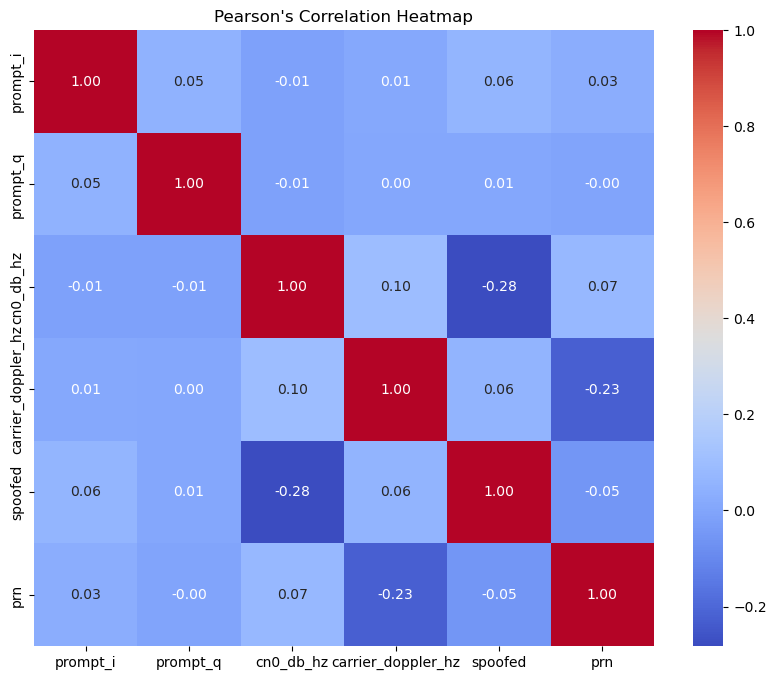

In [9]:
# Compute the correlation matrix
correlation_matrix_no_diff = big_df_no_diff.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_diff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [10]:
# SVM with no diff
X = big_df_no_diff.drop(columns=['spoofed', 'prn'])
y = big_df_no_diff['spoofed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [ ]:
model = SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()